In [1]:
import numpy as np
import scipy.sparse as scpsp
import tqdm
import matplotlib.pyplot as plt

In [2]:
# compile C code
import os, ctypes
from ctypes import c_int, c_float
fvec = np.ctypeslib.ndpointer(dtype=np.float32)
ivec = np.ctypeslib.ndpointer(dtype=np.int32)
os.system('gcc -fopenmp -O3 -mavx512f -ffast-math -mtune=native -march=native -c delays2.c -o delays2.c.o')
os.system('gcc -shared -fopenmp delays2.c.o -o delays2.c.so')
lib = ctypes.CDLL('./delays2.c.so')
lib.epi2d_dfun_batch.restype = None
lib.epi2d_dfun_batch.argtypes = (
    c_int, c_int,
    fvec, fvec, fvec, fvec, fvec, fvec, fvec,
    c_float, c_float
)
lib.delays1_batch.restype = None
lib.delays1_batch.argtypes = (
    c_int, c_int, c_int, c_int,
    fvec, fvec, fvec, ivec, ivec, ivec, fvec
)
lib.upbuf.restype = None
lib.upbuf.argtypes = (
    c_int, c_int, c_int, c_int,
    fvec, fvec
)
os.environ["OMP_NUM_THREADS"] = "32"

In [3]:
def heun(bs, nv, nh, i, dxz, xz, dt, x_0, lc, gc, xbuf, k_lc, k_gc, eps, theta, I, W, K, iL, iG):
    # eval coupling 1 or 2, depending on time step
    if i % 2 == 0:
        heavi = np.array(xz[0]>theta,'f') # heaviside step function coupling, upadte the buffer only according to threshold
        lib.upbuf(bs, nv, nh, i, xbuf, heavi) # update buffer
        lib.delays1_batch(bs, nv, nh, i+1, gc[0], xbuf, W.data, iL, W.indices, W.indptr, heavi) # global coupling
        lib.delays1_batch(bs, nv, nh, i+1, lc[0], xbuf, K.data, iG, K.indices, K.indptr, heavi) # local coupling

        # predictor stage
        lib.epi2d_dfun_batch(bs, nv, dxz[0], xz, lc[1], gc[1], x_0, k_lc, k_gc, eps, I)
        xzi = xz + dt*dxz[0]
        
        # corrector stage
        lib.epi2d_dfun_batch(bs, nv, dxz[1], xzi, lc[0], gc[0], x_0, k_lc, k_gc, eps, I)
        xz += dt/2*(dxz[0] + dxz[1])

    else:
        heavi = np.array(xz[0]>theta,'f') # heaviside step function coupling, upadte the buffer only according to threshold
        lib.upbuf(bs, nv, nh, i, xbuf, heavi) # update buffer
        lib.delays1_batch(bs, nv, nh, i+1, gc[1], xbuf, W.data, iL, W.indices, W.indptr, heavi) # global coupling
        lib.delays1_batch(bs, nv, nh, i+1, lc[1], xbuf, K.data, iG, K.indices, K.indptr, heavi) # local coupling

        # predictor stage
        lib.epi2d_dfun_batch(bs, nv, dxz[0], xz, lc[0], gc[0], x_0, k_lc, k_gc, eps, I)
        xzi = xz + dt*dxz[0]
        
        # corrector stage
        lib.epi2d_dfun_batch(bs, nv, dxz[1], xzi, lc[1], gc[1], x_0, k_lc, k_gc, eps, I)
        xz += dt/2*(dxz[0] + dxz[1])
    

In [4]:
for bs in [1,2,4,8,16,32,64,128]:
    print(f' n sims in parallel : {bs}') # = 32 # n sims in parallel
    gamma_range = np.linspace(0.001, 0.01, bs).astype('f')

    # load the global and local connectivity matrices
    lc_dist_mat = scpsp.load_npz('vert2vert_gdist_mat_32k.npz').astype('f')
    gc_dist_mat = scpsp.load_npz('vert2vert_lengths_32k_15M.npz').astype('f')
    gc_mat = scpsp.load_npz('vert2vert_weights_32k_15M.npz').astype('f')

    # make lc kernel from gdist
    lc_mat = lc_dist_mat.copy()
    lc_mat.data = np.exp(-lc_mat.data/5.0).astype('f')
    nv = lc_mat.shape[0]

    # take subset for benchmarking
    nv = np.int32(10*1024)
    gc_mat = gc_mat[:nv][:,:nv]
    lc_mat = lc_mat[:nv][:,:nv]
    gc_dist_mat = gc_dist_mat[:nv][:,:nv]
    lc_dist_mat = lc_dist_mat[:nv][:,:nv]

    # some parameters
    dt = np.float32(0.1)

    # prepare extra info for delays
    local_velocity = 6 # # Salami et al. 2002, intra-cortical conduction 10x slower 
    v2v_velocity = 6 #3.9 # according to Lemarechal et al. 2022
    igc = (gc_dist_mat / v2v_velocity / dt).astype('i')
    ilc = (lc_dist_mat / local_velocity / dt).astype('i')

    nh = np.max([igc.max(), ilc.max()])
    nh += 1 # add one to buffer 0 delay state
    # round up to the next power of 2
    nh = (2**np.ceil(np.log2(nh))).astype('i')   

    # allocate buffers
    xbuf = np.zeros((nv, nh, bs), 'f')  #-1.337896365956364   # initialise on fixed point
    dxz = np.zeros((2, 2, nv, bs), 'f')
    xz = np.zeros((2, nv, bs), 'f')
    xz[0,:] = -1.337896365956364
    xz[1,:] = -0.18514344764362828 # initialise on fixed point
    xz[1,:] = -0.3 # initialise some vertices slightly below fixed point so it triggers one oscillation

    x_0 = np.ones((nv, bs),"f") * -1.291610504045457 # set all vertices in excitable regime, won't oscillate on its own

    lc = np.zeros((2, nv, bs), 'f')
    gc = np.zeros((2, nv, bs), 'f')

    # set coupling strength
    gamma_lc = np.array([0.0],'f').repeat(bs) # ignore local coupling i.e. =0
    gamma_gc = np.array(gamma_range,'f')

    # local parameters
    I=np.float32(1.0)
    eps=np.float32(0.04)
    theta=np.float32(0.0)    

    nskip = 10
    niter = 1000
    x_trace = np.zeros((int(niter/nskip), nv, bs))
    for i in tqdm.trange(niter):
        heun(bs, nv, nh, i, dxz, xz, dt, x_0, lc, gc, xbuf, gamma_lc, gamma_gc, eps, theta, I, gc_mat, lc_mat, igc.data, ilc.data)
        if i % nskip == 0:
            x_trace[i//nskip,:,:] = xz[0,:,:].copy()

    if bs == 32:
        np.savez_compressed("epi2d-sim_batch_cpu_10k_vtx.npz", x_trace=x_trace)

 n sims in parallel : 1


100%|██████████| 1000/1000 [00:01<00:00, 686.23it/s]


 n sims in parallel : 2


100%|██████████| 1000/1000 [00:01<00:00, 594.69it/s]


 n sims in parallel : 4


100%|██████████| 1000/1000 [00:02<00:00, 412.67it/s]


 n sims in parallel : 8


100%|██████████| 1000/1000 [00:03<00:00, 327.40it/s]


 n sims in parallel : 16


100%|██████████| 1000/1000 [00:04<00:00, 229.77it/s]


 n sims in parallel : 32


100%|██████████| 1000/1000 [00:07<00:00, 131.66it/s]


 n sims in parallel : 64


100%|██████████| 1000/1000 [00:14<00:00, 69.74it/s]


 n sims in parallel : 128


100%|██████████| 1000/1000 [00:29<00:00, 33.88it/s]


# Compare GPU vs CPU results

In [5]:
x_trace_cpu = np.load("epi2d-sim_batch_cpu_10k_vtx.npz")["x_trace"]
x_trace_gpu = np.load("epi2d-sim_batch_gpu_10k_vtx.npz")["x_trace"]

In [6]:
x_trace_cpu.shape

(100, 10240, 32)

In [7]:
x_trace_gpu.shape

(100, 327680)

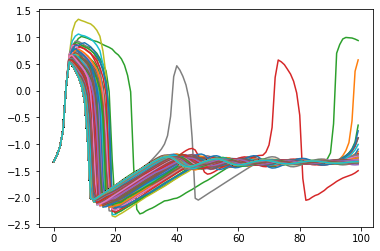

In [8]:
plt.plot(x_trace_cpu[:,:1000,30]);

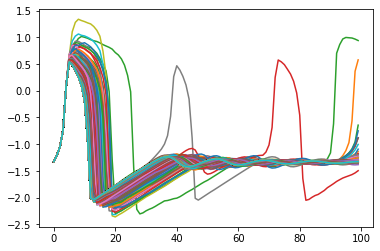

In [9]:
plt.plot(x_trace_gpu[:,30::32][:,:1000]);

In [10]:
for i in range(32):
    assert(np.allclose(x_trace_cpu[:,:,i], x_trace_gpu[:,i::32][:,:],1e-2, 1e-2))